# 02/22/23 - J1306 preparation. 
# This object was not in the HST ACS images that Matt Auger sent me.
# He reduced and sent me two different nights of observations on WFPC2 F606W
# I need to figure out how to combine them and get a PSF.

In [1]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
from os import path
import glob
#import Image from PIL
from PIL import Image
import pickle

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates
from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
from astropy.cosmology import Planck15 as cosmo  # Originally I did Planck 2018, but it seems this one isn't in the version of astropy we have on here and I'm not 
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized


# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.mge_half_light_isophote import mge_half_light_isophote
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
from slacs_mge_jampy import crop_center_image
from slacs_mge_jampy import import_center_crop
from slacs_mge_jampy import try_fractions_for_find_galaxy
from slacs_mge_jampy import convert_mge_model_outputs
from slacs_mge_jampy import plot_contours_531
from slacs_mge_jampy import load_2d_kinematics
from slacs_mge_jampy import load_2d_kinematics_with_datacube_contours
from slacs_mge_jampy import bin_velocity_maps
from slacs_mge_jampy import rotate_bins
from slacs_mge_jampy import osipkov_merritt_model
from slacs_mge_jampy import find_half_light
from slacs_mge_jampy import calculate_minlevel
from slacs_mge_jampy import fit_kcwi_sigma_psf
from slacs_mge_jampy import optimize_sigma_psf_fit
from slacs_mge_jampy import estimate_hst_psf
from slacs_mge_jampy import plot_kinematics_mge_contours
from slacs_mge_jampy import jampy_details

################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.05 # WFPC2/WF3


In [2]:
# specify object directory and name

data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/' # data directory
table_dir = f'{data_dir}tables/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'

obj_name = 'SDSSJ1306+0600'

In [3]:
3/hst_scale

60.0

# We have two observations on different nights... How to put them together?

<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7feb1617a630>]>
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1922                                                  NAXIS2  =                 1935                                                  EXTEND  =                    T                                                  CRPIX1  =                961.0                                                  CRPIX2  =                967.5                                                  CRVAL1  =    196.5567845112902                                                  CRVAL2  =    6.005651022120135                                                  CD1_1   = -1.3888888888888E-05                                                  CD1_2   =              

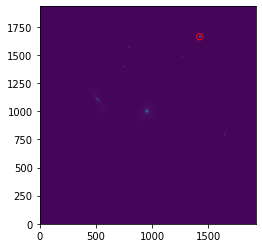

In [4]:
# look at first image

hdul = fits.open('/data/raw_data/HST_SLACS_ACS/J1306+0600_WFPC2_F606W/J1306+0600_F606W_u9op52_3_sci.fits')
hdul.verify('fix')
print(hdul.info)
data1 = hdul[0].data
header1 = hdul[0].header
print(header1)
central_pix = np.unravel_index(np.argmax(data1, axis=None), data1.shape)
xc = central_pix[1]
yc = central_pix[0]
plt.imshow(data1, origin='lower')
plt.scatter(xc, yc, facecolor='None', edgecolor='r', s=40)
hdul.close()

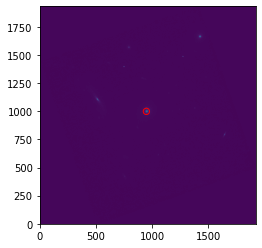

In [5]:
# It's not the right one. Use a different technique. Second argmax?
central_pix = np.unravel_index(np.argsort(data1, axis=None)[-2], data1.shape)
xc = central_pix[1]
yc = central_pix[0]
plt.imshow(data1, origin='lower')
plt.scatter(xc, yc, facecolor='None', edgecolor='r', s=40)


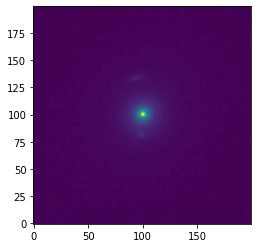

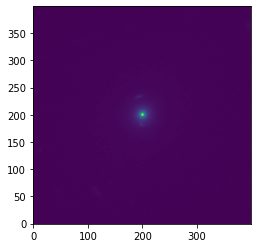

In [6]:
w = int(5/hst_scale) # crop to 5 arcsec radius
crop_data1 = data1[yc-w:yc+w,xc-w:xc+w]
plt.imshow(crop_data1, origin='lower')
plt.pause(1)
plt.clf()

# crop one to 10 arcsec as well
w10 = int(10/hst_scale)
crop_data1_10 = data1[yc-w10:yc+w10,xc-w10:xc+w10]
plt.imshow(crop_data1_10, origin='lower')


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7feb0beaa6a0>]>
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 2087                                                  NAXIS2  =                 2062                                                  EXTEND  =                    T                                                  CRPIX1  =               1043.5                                                  CRPIX2  =               1031.0                                                  CRVAL1  =    196.5564917922205                                                  CRVAL2  =    6.005828661684845                                                  CD1_1   = -1.3888888888888E-05                                                  CD1_2   =              

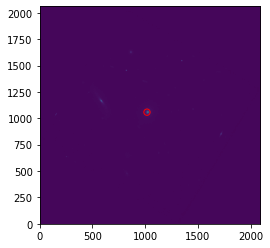

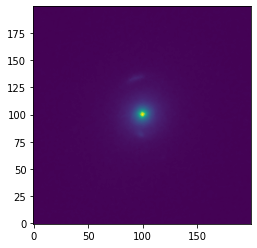

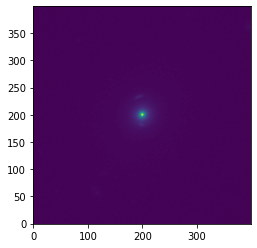

In [7]:
# look at second image

#'data/raw_data/HST_SLACS_ACS/J1306+0600_WFPC2_F606W/J1306+0600_F606W_ua1l36_3_sci.fits
hdul = fits.open('/data/raw_data/HST_SLACS_ACS/J1306+0600_WFPC2_F606W/J1306+0600_F606W_ua1l36_3_sci.fits')
hdul.verify('fix')
print(hdul.info)
data2 = hdul[0].data
header2 = hdul[0].header
print(header2)

central_pix = np.unravel_index(np.argmax(data2, axis=None), data2.shape)
xc = central_pix[1]
yc = central_pix[0] 

w = int(5/hst_scale) # crop to 5 arcsec radius
plt.imshow(data2, origin='lower')
plt.scatter(xc, yc, facecolor='None', edgecolor='r', s=40)
plt.pause(1)
plt.clf()
crop_data2 = data2[yc-w:yc+w,xc-w:xc+w]
plt.imshow(crop_data2, origin='lower')


plt.pause(1)
plt.clf()

# crop one to 10 arcsec as well
crop_data2_10 = data2[yc-w10:yc+w10,xc-w10:xc+w10]
plt.imshow(crop_data2_10, origin='lower')


hdul.close()

# There is no rotation given in the header. I bet they're aligned. Check the residual.

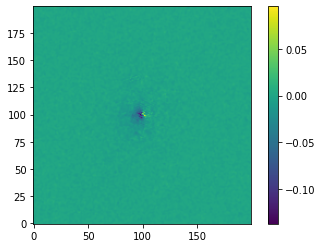

In [8]:
a = plt.imshow((crop_data1/np.max(crop_data1))-(crop_data2/np.max(crop_data2)), origin='lower') # normalize each to brightest pixel
plt.colorbar(a)

# Looks good!

# From HLA, they are each 400 s exposure time.
# The first image is from 2007-03-23 PI Adam Bolton and is on the HLA as the combined image from four exposures.
# Second image is from 2008-02-08 PI Leon Koopmans and is on HLA as 4 different exposures. Matt Auger combined these for me.
# I am going to add the exposure times and date to the headers.
https://hla.stsci.edu/hlaview.html#Inventory|filterText%3D%24filterTypes%3D|query_string=SDSSJ1306%2B0600&posfilename=&poslocalname=&posfilecount=&listdelimiter=whitespace&listformat=degrees&RA=196.556870&Dec=6.006140&Radius=0.001500&inst-control=all&inst=ACS&inst=ACSGrism&inst=WFC3&inst=WFPC2&inst=NICMOS&inst=NICGRISM&inst=COS&inst=WFPC2-PC&inst=STIS&inst=FOS&inst=GHRS&imagetype=best&prop_id=&spectral_elt=&proprietary=both&preview=1&output_size=256&cutout_size=12.8|ra=&dec=&sr=&level=&image=&inst=ACS%2CACSGrism%2CWFC3%2CWFPC2%2CNICMOS%2CNICGRISM%2CCOS%2CWFPC2-PC%2CSTIS%2CFOS%2CGHRS&ds=

In [9]:
header1['EXP_TIME'] = 1600 # s
header1['date'] = '2007-03-23' 
header1['PI'] = 'Adam Bolton' 
header1['camera'] = 'WFPC2 - WF3'
header1['HLA'] = 'combined 4'

header2['EXP_TIME'] = 1600 # s
header2['date'] = '2008-02-08' 
header2['PI'] = 'Leon Koopmans'
header2['camera'] = 'WFPC2 - WF3'
header2['HLA'] = '4 exp, combined by M Auger'

In [10]:
header1

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1922                                                  
NAXIS2  =                 1935                                                  
EXTEND  =                    T                                                  
CRPIX1  =                961.0                                                  
CRPIX2  =                967.5                                                  
CRVAL1  =    196.5567845112902                                                  
CRVAL2  =    6.005651022120135                                                  
CD1_1   = -1.3888888888888E-05                                                  
CD1_2   =                  0.0                                                  
CD2_1   =                  0

# Add them together and see!

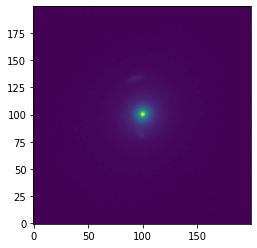

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


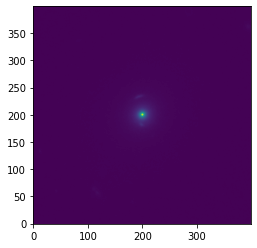

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


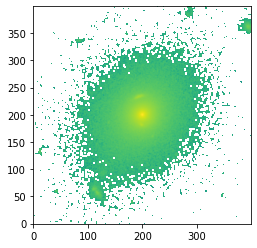

In [11]:
hst_img = (crop_data1+crop_data2)*3200 # in counts from the total exposure time
plt.imshow(hst_img, origin='lower')
plt.pause(1)
plt.clf()
plt.imshow(np.log10(hst_img), origin='lower')

hst_img_10 = (crop_data1_10+crop_data2_10)*3200
plt.imshow(hst_img_10, origin='lower')
plt.pause(1)
plt.clf()
plt.imshow(np.log10(hst_img_10), origin='lower')

# Okay, this image should work. Now how to do a PSF.
## I used Tiny Tim to create a PSF by selecting the following options:
WFPC2, chip 3, position 400 400, filter F606W, spectrum G5V, 3 arcsec size, no subsampling, secondary mirror despace 0.011 microns, filename j1306_wfpc2

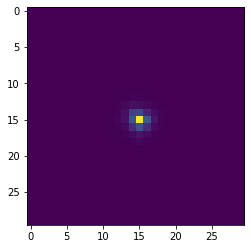

In [12]:
psf_file = f'{data_dir}mosaics/{obj_name}/j1306_wfpc200.fits'
hdul = fits.open(psf_file)
psf = hdul[0].data
plt.imshow(psf)

# Let's try using J1306's spectrum. Must be a specfic format for Tiny Tim.

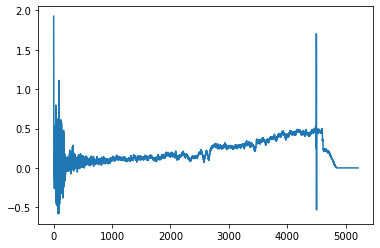

In [13]:
spectrum_file = f'{data_dir}mosaics/{obj_name}/J1306_central_spectrum_R2.fits'
hdul = fits.open(spectrum_file)
hdul.verify('fix')
spectrum = hdul[0].data
header = hdul[0].header
hdul.close()
plt.plot(spectrum)

wavelengths = np.linspace(header['WAVALL0'], header['WAVALL1'], len(spectrum))
spectrum_tinytim = np.vstack((wavelengths, spectrum)).T
# save as a txt file with a header "PHOTLAM"
# already saved... np.savetxt(f'{data_dir}mosaics/{obj_name}/spectrum_tinytim.txt', spectrum_tinytim, header='PHOTLAM')

# Now bring in the output from Tiny Tim
WFPC2, chip 3, position 400 400, filter F606W, spectrum from J1306, 3 arcsec size, no subsampling, secondary mirror despace 0.011 microns, filename j1306_wfpc2

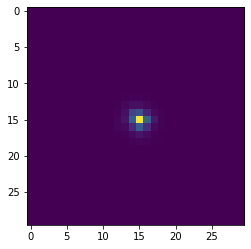

In [14]:
psf_file = f'{data_dir}mosaics/{obj_name}/J1306_psf.fits'
hdul = fits.open(psf_file)
psf = hdul[0].data
plt.imshow(psf)

# Cool, we got it.
____

Now we can run things. Follow "plot_kinematics_contours_V_VD_bspline_models_012423.ipynb" because several of the functions will have to be adjusted.

In [15]:
obj_names = np.array(['SDSSJ0029-0055', 'SDSSJ0037-0942', 'SDSSJ0330-0020',
        'SDSSJ1112+0826', 'SDSSJ1204+0358', 'SDSSJ1250+0523',
        'SDSSJ1306+0600', 'SDSSJ1402+6321', 'SDSSJ1531-0105',
        'SDSSJ1538+5817', 'SDSSJ1621+3931', 'SDSSJ1627-0053',
        'SDSSJ1630+4520', 'SDSSJ2303+1422'])

In [16]:
kcwi_pas = np.array([0,
                    0,
                    90,
                    0,
                    50,
                    -30,
                    60,
                    -20,
                    45,
                    0,
                    -45,
                    90,
                    -20,
                    -45]
                   )

np.savetxt(f'{data_dir}tables/kcwi_pas.txt', kcwi_pas)

In [17]:
obj_names

array(['SDSSJ0029-0055', 'SDSSJ0037-0942', 'SDSSJ0330-0020',
       'SDSSJ1112+0826', 'SDSSJ1204+0358', 'SDSSJ1250+0523',
       'SDSSJ1306+0600', 'SDSSJ1402+6321', 'SDSSJ1531-0105',
       'SDSSJ1538+5817', 'SDSSJ1621+3931', 'SDSSJ1627-0053',
       'SDSSJ1630+4520', 'SDSSJ2303+1422'], dtype='<U14')

In [18]:
obj_names[obj_names==obj_name]

array(['SDSSJ1306+0600'], dtype='<U14')

In [19]:
obj_names==obj_name

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False])

In [20]:
kcwi_pas[obj_names==obj_name]

array([60])

In [21]:
class jampy_details:
    
    def __init__(details, surf_density, mge_sigma, q, kcwi_sigmapst, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff):
        details.surf_density=surf_density 
        details.mge_sigma=mge_sigma
        details.q=q 
        details.kcwi_sigmapst=kcwi_sigmapst 
        details.Vrms_bin=Vrms_bin 
        details.dVrms_bind=Vrms_bin
        details.V_bin=V_bin 
        details.dV_bin=dV_bin 
        details.xbin_phot=xbin_phot 
        details.ybin_phot=ybin_phot
        details.reff=reff

In [22]:
def import_center_crop (file_dir, obj_name, obj_abbr, data_source='HST', plot=True):

    '''
    This function imports a file from the object directory, crops the image to 5 and 3 arcsec, and returns all images. 
    *****
    This is modified from other versions to pull in the SLACS bspline model instead of the observed HST image
    *****

    Inputs:
        file_dir - contains the directory containing the object's image files
        obj_name - SDSS name, e.g. SDSSJ0037-0942
        obj_abbr - SDSS name, e.g. SDSSJ0037-0942 abbreviated to J0037
        data_source - which image is used, by default HST; if kcwi_datacube, use image integrated over the spectrom so it's a 2D image instead of the cube
        plot - Return both images in line

    Returns:
        _img - file image with arcsec axes, in counts
        _5arc_img
        _3arc_img = image cropped to 3 arcsecond radius, in counts
        header = input fits file header, in counts
    '''

     ##############################################################################
    # kcwi datacube

    if data_source == 'kcwi_datacube':

        file = file_dir + f"KCWI_{obj_abbr}_icubes_mosaic_0.1457_2D_integrated.fits"
        hdu = fits.open(file)
        kcwi_img = hdu[0].data
        header = hdu[0].header
        
        # get kcwi position angle N thru E
        # bring kcwi_pas.txt 
        kcwi_pas = np.genfromtxt(f'{data_dir}tables/kcwi_pas.txt')
        kcwi_pa = kcwi_pas[obj_names==obj_name]
        kcwi_pa_header = header['ROTDEST'] # I still haven't determined what this angle is relative to. I *believe* it's N->E
        
        if kcwi_pa != kcwi_pa_header:
            print('PA in header doesnt match')
        
        if kcwi_pa != 0:
            # rotate by the kcwi pa
            kcwi_img = rotate(kcwi_img, -kcwi_pa)
            print('Rotate image by ', kcwi_pa)
        
        # pixel scale
        kcwi_scale = 0.1457  # arcsec/pixel r_eff_V
        img_half_extent = kcwi_img.shape[0]/2 * kcwi_scale
        
        # crop the image to ~ 5 arcsec radius
        kcwi_5arc_img, central_pix_x, central_pix_y = crop_center_image(kcwi_img, 5, kcwi_scale, 'argmax')

        # crop the image to ~ 3 arcsec radius
        kcwi_3arc_img, central_pix_x_3, central_pix_y_3 = crop_center_image(kcwi_img, 3, kcwi_scale, 'argmax')
        
        if plot == True:
            # plot full image
            plt.clf()
            plt.figure(figsize=(12,4))
            plt.subplot(131)
            plt.imshow(kcwi_img, origin='lower',
                       extent = [-img_half_extent,img_half_extent,-img_half_extent,img_half_extent])
            plt.title('KCWI datacube')
            # plot cropped images
            plt.subplot(132)
            plt.imshow(kcwi_5arc_img, origin='lower', extent=[-5,5,-5,5])#, extent=[0,50,0,50])
            plt.contour(kcwi_5arc_img, colors='grey', extent=[-5,5,-5,5])
            plt.title('KCWI datacube')
            plt.subplot(133)
            plt.imshow(kcwi_3arc_img, origin='lower', extent=[-3,3,-3,3])#, extent=[0,50,0,50])
            plt.contour(kcwi_3arc_img, colors='grey', extent=[-3,3,-3,3])
            plt.title('KCWI datacube')
            plt.pause(1)

        return(kcwi_img, kcwi_5arc_img, kcwi_3arc_img, header, central_pix_x, central_pix_y, kcwi_pa)

   ###################################################################################
    # HST cutout

    elif data_source == 'HST':
        
        # take the F435 file if it exists, else take the F814 (if two entries for same filter take first)
        files_F435 = glob.glob(f'{file_dir}*{obj_abbr}*435*.fits')
        files_F814 = glob.glob(f'{file_dir}*{obj_abbr}*814*.fits')
        if files_F435:
            file = files_F435[0] # take the first entry of F435
            filter_name = 'F435W'
        elif files_F814:
            file = files_F814[0] # take the first entry of F814
            filter_name = 'F814W'
        else:
            print('no file')
        
        hdu = fits.open(file)
        hst_img = hdu[0].data #### HST data is in counts/second
        bspl_img = hdu[8].data #### HST data is in counts/second # index 8 is the b-spline model
        header = hdu[0].header
        
        # multiply by exp_time to get counts
        exp_time = header['EXPTIME']
        hst_img = hst_img * exp_time
        bspl_img = bspl_img * exp_time

        # pixel scale
        hst_scale = 0.050 # ACS/WFC
        img_half_extent = hst_img.shape[0]/2 * hst_scale
        
        # crop the image to 5 arcsec
        hst_5arc_img, central_pix_x, central_pix_y = crop_center_image(hst_img, 5, hst_scale, 'center')
        bspl_5arc_img, _, _ = crop_center_image(bspl_img, 5, hst_scale, 'center')
        
        # crop the image to 3 arcsec
        hst_3arc_img, central_pix_x_3, central_pix_y_3 = crop_center_image(hst_img, 3, hst_scale, 'center')
        bspl_3arc_img, _, _ = crop_center_image(bspl_img, 5, hst_scale, 'center')

        if plot == True:
            # plot the image
            plt.clf()
            plt.figure(figsize=(12,4))
            plt.subplot(131)
            plt.imshow(hst_img, origin='lower',
                       extent = [-img_half_extent,img_half_extent,-img_half_extent,img_half_extent]) 
            plt.title(f'HST {filter_name}')
            # plot cropped image   
            plt.subplot(132)
            plt.imshow(hst_5arc_img, origin='lower', extent=[-5,5,-5,5])
            plt.contour(hst_5arc_img, colors='k', extent=[-5,5,-5,5])
            plt.title(f'HST {filter_name}')
            plt.subplot(133)
            plt.imshow(hst_3arc_img, origin='lower', extent=[-3,3,-3,3])
            plt.contour(hst_3arc_img, colors='k', extent=[-3,3,-3,3])
            plt.title(f'HST {filter_name}')
            plt.pause(1)
            
            #plot the bspline model
            plt.clf()
            plt.figure(figsize=(12,4))
            plt.subplot(131)
            plt.imshow(bspl_img, origin='lower',
                       extent = [-img_half_extent,img_half_extent,-img_half_extent,img_half_extent]) 
            plt.title(f'HST bspline {filter_name}')
            # plot cropped image   
            plt.subplot(132)
            plt.imshow(bspl_5arc_img, origin='lower', extent=[-5,5,-5,5])
            plt.contour(bspl_5arc_img, colors='k', extent=[-5,5,-5,5])
            plt.title(f'HST bspline {filter_name}')
            plt.subplot(133)
            plt.imshow(bspl_3arc_img, origin='lower', extent=[-3,3,-3,3])
            plt.contour(bspl_3arc_img, colors='k', extent=[-3,3,-3,3])
            plt.title(f'HST bspline {filter_name}')
            plt.pause(1)

        return(hst_img, hst_5arc_img, hst_3arc_img, bspl_img, bspl_5arc_img, bspl_3arc_img, header, central_pix_x, central_pix_y, exp_time)


################################################
Getting KCWI datacube
PA in header doesnt match
Rotate image by  [60.]


<Figure size 432x288 with 0 Axes>

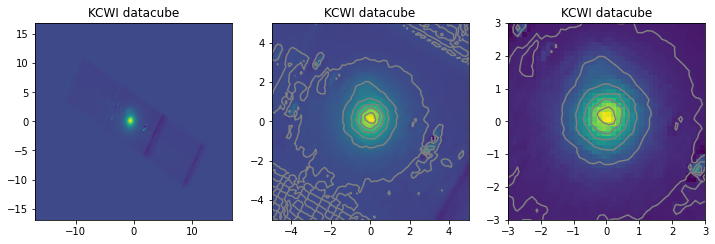

In [23]:
obj_abbr = obj_name[4:9] # e.g. J0029
file_dir = f'{data_dir}mosaics/{obj_name}/' # directory with all files of obj_name

# import image, center, and crop
#######################################################################################
# kcwi datacube

print('################################################')
print('Getting KCWI datacube')

kcwi_img, kcwi_5arc_img, kcwi_3arc_img, kcwi_header, \
    kcwi_central_pix_x, kcwi_central_pix_y, kcwi_pa = import_center_crop(file_dir, obj_name, obj_abbr, 
                                                                          data_source='kcwi_datacube', plot=True)

# Something is wrong... This says that the KCWI observations had no rotation, but I know that's not true. PA was 60.

In [28]:
########################################################################################

def optimize_sigma_psf_fit (fit_kcwi_sigma_psf, sigma_psf_guess=0.5, offset_x_guess=0., offset_y_guess=0., # use offset 
                            hst_img=None, kcwi_img=None, hst_scale=0.050, kcwi_scale=0.1457, plot=True):
    '''
    Function to optimize with least squares optimization the fit of KCWI sigma_psf by convolving the HST img
    with Gaussian PSF.
    Inputs:
        - fit_kcwi_sigma_psf - function that fits the KCWI image with HST image convolved with a sigma_psf
        - sigma_psf_guess - float, first guess at the sigma_psf value, pixels
        - hst_img 
        - kcwi_img
    '''
    
    x0 = np.array([sigma_psf_guess, offset_x_guess, offset_y_guess], dtype=float)
    bounds = np.array([[0.1, -np.inf, -np.inf],[3.0, np.inf, np.inf]])
    
    # optimize the function
    result = lsq(fit_kcwi_sigma_psf, x0=x0, bounds=bounds, kwargs={'hst_img':hst_img,'kcwi_img':kcwi_img,
                                                                 'plot':False})
    print(result.x.shape)
    # state the best-fit sigma-psf and loss function value
    best_fit_psf = result.x[0]
    offset_x = result.x[1]
    offset_y = result.x[2]
    loss = result.cost
    print(result.status)
    print(f'Best fit sigma-PSF is {best_fit_psf} arcsec')
    print(f'Best fit loss function value is {loss}')
    print(f'Offsets: {offset_x},{offset_y}')
    
    # take best_residual
    best_residual = result.fun.reshape(kcwi_img.shape)
    print(f'Sum residual {np.sum(abs(best_residual))}')
    
    # show residual
    if plot == True:
        plt.figure()
        plt.imshow(best_residual, origin='lower')
        plt.colorbar()
        plt.title('Best fit residual')
        plt.pause(1)
        plt.clf()
        
    return best_fit_psf, loss, best_residual

#########################################################################

def estimate_hst_psf_j1306 (file_dir, obj_name, obj_abbr, 
                          # specifice to j1306
                            hst_psf_model,
                          ngauss=12, frac=1., scale=0.050, minlevel=0., qbounds=[0.98,1.]):
    '''
    Opens fits file containing psf model from M Auger and estimates the psf with Gaussian MGE formalism
    Inputs:
        - file_dir - directory containing all files for object
        - obj_name - name of object, e.g. SDSSJ0037-0942
        - obj_abbr - abbreviation of obj, e.g. J0037
        - ngauss - int, number of Gaussians to try, will likely not need all of them, default 12
        - frac - float, fraction of pixels to use, default 1.
        - scale - hst pixel scale, 0.050
        - minlevel - float, minimum level pixel value to include in photometric fit; raise it to mask noise
        - qbound - boundaries for the axial ratio q; psf should be ~ 1
    '''
    
    #print(hst_psf_header) # header is not useful
    plt.imshow(hst_psf_model)

    ###########################################################################
    # Model the central light ellipse

    plt.clf()
    #plt.clf()
    f = find_galaxy(hst_psf_model, fraction=frac, plot=1, quiet=True)
    eps = f.eps
    theta = f.theta
    cen_y = f.ypeak
    cen_x = f.xpeak
    plt.title(f'{frac}')
    plt.pause(1)

    ###########################################################################
    # run sectors photometry
    
    plt.clf()
    s = sectors_photometry(hst_psf_model, eps, theta, cen_x, cen_y, minlevel=minlevel, plot=1)
    plt.pause(1)  # Allow plot to appear on the screen

    ###########################################################################
    # fit and plot

    plt.clf()
    m = mge_fit_sectors(s.radius, s.angle, s.counts, eps,
                        ngauss=ngauss, qbounds=qbounds,
                        scale=scale, plot=1, bulge_disk=0, linear=0)
    plt.pause(1) 

    #############################################################################
    # take the output weights and sigmas for each Gaussian

    hst_psf_weights = m.sol[0] # unnormalized weights in counts of each Gaussian
    hst_normpsf = hst_psf_weights / np.sum(hst_psf_weights) # normalized weights for psf
    hst_sigmapsf = m.sol[1] # sigma of each Gaussian

    print('How good is the fit? Should be low (~ 0.02)... ' + str(m.absdev))

    # Datapoints that drop off sharply at large radii worsen the fit and should be removed as skylevel.
    
    return hst_sigmapsf, hst_normpsf

###############################################################################################################################

# define function to do all of the steps together

def plot_kinematics_mge_contours_j1306 (data_dir, hst_dir, obj_name, frac, levels, binning, magsteps, magrange,
                                  # now things specific to j1306
                                        hst_img, hst_img_10, hst_psf_model, exp_time,
                                  align_phot=False, add_rot_phot=False, add_rot_kin=False, skip_kcwi=False, debug=False):

    print('#####################################################################################################################')
    print('#####################################################################################################################')
    print()
    print(f'Beginning final kinematics visualization and plotting for object {obj_name}.')
    print()

    obj_abbr = obj_name[4:9] # e.g. J0029
    file_dir = f'{data_dir}mosaics/{obj_name}/' # directory with all files of obj_name

    # import image, center, and crop
    #######################################################################################
    # kcwi datacube
    
    print('################################################')
    print('Getting KCWI datacube')

    kcwi_img, kcwi_5arc_img, kcwi_3arc_img, kcwi_header, \
        kcwi_central_pix_x, kcwi_central_pix_y, kcwi_pa = import_center_crop(file_dir, obj_name, obj_abbr, 
                                                                              data_source='kcwi_datacube', plot=True)

    #######################################################################################
    # take 5 arcsec images
    # TAKE THE FULL bspline IMAGE FOR MGE FITTING. THE CONTOURS ARE NOT RIGHT WHEN I FIT THE 5 ARCSEC IMAGE
    # 
    
    img = hst_img# bspl_full_img # This is the image that will be fit with MGE
    img_10 = hst_img_10 # These three will be used to plot, e.g. the log image
    #bspl_img = bspl_5arc_img
    kcwi_img = kcwi_5arc_img

    #######################################################################################
    # calculate the minimum level for inclusion in the photometry fitting from the background
    # minlevel is half the std of the sky patch, this value is for the sectors_photometry function
    # skylevel (std of sky patch) is for smoothing the log image for plotting next to the contours
    
    print('################################################')
    print('Calculating sky level')

    size=50
    minlevel, noise = calculate_minlevel(img_10, size) 
    skylevel = minlevel*2

    ################################################
    # smooth the log image for viewing
    
    print('################################################')
    print('Smoothed log images for viewing')

    log_hst_img = np.log10(hst_img.clip(skylevel))
    plt.imshow(log_hst_img, extent=[-5,5,-5,5], origin='lower')
    plt.title(f'{obj_name} HST log image')
    plt.savefig(f'{file_dir}{obj_name}_hst_log_image.png')
    plt.pause(1)
    plt.clf()
    

    #######################################################################################
    # estimate psfs
    
    print('################################################')
    print('Estimating PSFs')

    #################################################
    # estimate kcwi psf
    
    print('################################################')
    print('KCWI PSF from hst image')
    
    # rotate the kcwi image by the kcwi pa to align them... I didn't do this
    
    # debug block
    if debug==False:
        kcwi_sigmapsf, loss, residual = optimize_sigma_psf_fit (fit_kcwi_sigma_psf, hst_img=hst_img, kcwi_img=kcwi_img, plot=True)
    else:
        kcwi_sigmapsf=-1
    
    # kcwi_sigmapsf is the sigma of a circular gaussian psf, not an mge deconstruction
    kcwi_psf_fwhm = 2.355*kcwi_sigmapsf
    
    print(f'KCWI PSF FWHM = {kcwi_psf_fwhm} arcsec')
    if kcwi_psf_fwhm < 0.5:
        print('KCWI PSF should not be that low.')
        # write lines for log
        l1 = '\n######################################'
        l2 = f'\n{obj_name}'
        l3 = f'\nKCWI PSF FWHM: {kcwi_psf_fwhm}'
        file = open('flag_log.txt', 'a')
        file.writelines([l1, l2, l3])
    
    #################################################
    # estimate hst psf
    
    print('################################################')
    print('HST PSF')
    
    # estimate without lower minvalue 
    if debug==False:
        estimate_hst_psf_j1306(hst_dir, obj_name, obj_abbr, hst_psf_model)

    #################################################
    # Check the minlevel by eye
    print('Check this minlevel')
    minlevel = 2*1e-6 # this value is typically much lower than needed

    # find sigmapsf and normpsf of hst image
    hst_sigmapsf, hst_normpsf = estimate_hst_psf_j1306(hst_dir, obj_name, obj_abbr, hst_psf_model, minlevel=minlevel)
    # circular psf is weighted mean
    #print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! normpsf is ', hst_normpsf)
    #print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! sigmapsf is ', hst_sigmapsf)
    hst_sigmapsf_circ = np.average(hst_sigmapsf, weights=hst_normpsf)*hst_scale
    print('mean psf sigma is ', hst_sigmapsf_circ)
    hst_psf_fwhm = 2.355*hst_sigmapsf_circ
    print(f'HST PSF FWHM = {hst_psf_fwhm} arcsec')
    if hst_psf_fwhm < 0.1:
        print('HST PSF should not be that low.')
        # write lines for log
        l1 = '\n######################################'
        l2 = f'\n{obj_name}'
        l3 = f'\nHST PSF FWHM: {hst_psf_fwhm}'
        file = open(f'flag_log.txt', 'a')
        file.writelines([l1, l2, l3])

    #######################################################################################
    # fit the photometry
    
    print('################################################')
    print('Fitting photometry')

    #################################################
    # Model the central light ellipse
    
    print('################################################')
    print('First fit of central light ellipse')

    plt.clf()
    #plt.clf()
    f = find_galaxy(img, fraction=frac, plot=1, quiet=True)
    eps = f.eps
    theta = f.theta
    cen_y = f.ypeak
    cen_x = f.xpeak
    #plt.contour(img, colors='grey', extent=[-3,3,-3,3], levels=[0.1, 0.2, 0.4, 0.7, 1.0], zorder=1)
    plt.title(f'fract: {frac}, theta: {np.around(theta,2)}')
    plt.pause(1)

    ################################################
    # Perform galaxy photometry with full image
    
    print('################################################')
    print('Calculating photometry of sectors')

    plt.clf()
    s = sectors_photometry(img, eps, theta, cen_x, cen_y, minlevel=minlevel, plot=1)
    plt.pause(1)  # Allow plot to appear on the screen

    ################################################
    # Do the first MGE fit
    
    print('################################################')
    print('First MGE fit')

    # select number of gaussians to fit
    ngauss = 12

    # pixel scale
    scale = hst_scale

    # psf - take from the MGE psf model above
    sigmapsf = hst_sigmapsf
    normpsf = hst_normpsf
    #seeing_fwhm = 0.8 # arcsec
    #sigmapsf = seeing_fwhm / scale / 2.355 # pixels, 2.355 is fwhm/sigma
    #normpsf = 1

    # exposure time
    #exp_time = hstF435_header['EXPTIME']

    # fit and plot

    plt.clf()
    m = mge_fit_sectors(s.radius, s.angle, s.counts, eps,
                        ngauss=ngauss, sigmapsf=sigmapsf, normpsf=normpsf,
                        scale=scale, plot=1, bulge_disk=0, linear=0,
                       quiet=True)
    plt.pause(1)

    # plot the contours on the image
    plot_contours_531 (img, f, m, sigmapsf, normpsf, contour_alpha=0.4, data_source='HST')

    ######################################################
    # Do the actual MGE fit
    
    print('################################################')
    print('Regularized MGE fit')

    # fit and plot

    plt.clf()
    m = mge_fit_sectors_regularized(s.radius, s.angle, s.counts, eps,
                        ngauss=ngauss, sigmapsf=sigmapsf, normpsf=normpsf,
                        scale=scale, plot=1, bulge_disk=0, linear=0,
                                   quiet=True)
    plt.pause(1) 
    
        
    # update the ellipticity measurement
    # m solution has set of Gaussians, weight by the normalized total counts and average to get the best estimate
    weights = m.sol[0]/np.sum(m.sol[0])
    qs = m.sol[2]
    q = np.sum(weights*qs)
    ellipticity = 1 - q
    print(f'Best fit ellipticity = {ellipticity}')

    # plot the contours on the image
    plot_contours_531 (img, f, m, sigmapsf, normpsf, contour_alpha=0.4, data_source='HST')
    
    ########### NEW THING FROM JAM NOTEBOOK###############################
    print('################################################')
    print('Converting to surface density and real units!')
    # bring in dust extinction table
    extinctions = pd.read_csv(f'{table_dir}slacs_Iband_extinctions.csv')
    extinction = extinctions.loc[extinctions.obj_name == obj_name, 'A_I'].values[0]
    # convert sigma (of gaussian components) from pixels to arcsec and surface brightness to surface density
    mge_sigma, surf_density = convert_mge_model_outputs (m, exp_time, extinction, qs, data_source='F435W')
    
    #######################################
    # get reff
    print('#################################################')
    print('Calculating half-light isophote and circularized half-light radius')
    reff, reff_maj, eps_e, lum_tot = mge_half_light_isophote(surf_density, mge_sigma, qs)
    # slacs reff
    slacs_table = np.genfromtxt(f'{table_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
    slacs_table_name = obj_name[4:]
    slacs_reffs = slacs_table[:,7].astype(float)
    reff_slacs = slacs_reffs[slacs_table[:,0]==slacs_table_name]
    print('effective radius mge: ', reff)
    print('effective radius slacs: ', reff_slacs)
    if reff < 0.5*reff_slacs:
        print('Effective radius should not be that small')
        # write lines for log
        l1 = '\n######################################'
        l2 = f'\n{obj_name}'
        l3 = f'\nEffective radius from MGE: {reff}'
        l4 = f'\nEffective radius from SLACS: {reff_slacs}'
        file = open(f'flag_log.txt', 'a')
        file.writelines([l1, l2, l3, l4])
        
    #######################################################################################
    # bring in kinematics
    
    print('################################################')
    print('Loading kinematics')

    V, VD, Vrms, \
    dV, dVD, dVrms = load_2d_kinematics_with_datacube_contours (file_dir, obj_name, img/np.max(img), f,
                                                                           radius=5, contour_alpha=0.7, data_source='HST', 
                                                                           plot=True, plot_img=False)
    
    # remove pixels that have VD > 350

    ################################################
    # bin velocity maps
    
    print('################################################')
    print('Binning velocity maps')

    #V_bin, VD_bin, Vrms_bin, \
    #dV_bin, dVD_bin, dVrms_bin, \
    V_bin, VD_bin,  \
    dV_bin, dVD_bin, \
    xbin_arcsec, ybin_arcsec = bin_velocity_maps (file_dir, obj_name, data_source='KCWI')

    # Check binning

    # plot with arcsec
    width =  V.shape[0]/2 * kcwi_scale
    extent = [-width,width,-width,width]
    plt.figure(figsize=(8,8))
    plt.imshow(V, origin='lower', extent=extent, cmap='sauron')
    plt.scatter(xbin_arcsec, ybin_arcsec, color='k', marker='.')

    ##################################################
    # correct barycenter velocity and PA
    
    print('################################################')
    print('Correcting barycentre velocity and calculating PA_kin')
    
    # kinematic PA is measured from the kinematic map's N thru E (ie. "counter clockwise of up", if KCWI aperture position angle was not set to 0, this will not be really north)
    PA_kin_, dPA_kin, velocity_offset = fit_kinematic_pa(xbin_arcsec, ybin_arcsec, V_bin)#, debug=debug)
    # convert to N thru E
    PA_kin = PA_kin_ + kcwi_pa
    
    plt.pause(1)
    plt.clf()

    # Correct the velocity
    V = V - velocity_offset
    V_bin = V_bin - velocity_offset

    # PA_phot is theta from find_galaxy, measured from negative x-axis
    # convert to N thru E (this will be true north because HST images are oriented that way [I think...])
    PA_phot = 270 - theta

    ##################################################
    # rotate the bins by the kinematics PA and the photometric PA
    # plot the rotation with the "non-symmetrized velocity field"
    
    #print('################################################')
    print('Checking PA by rotating bins by each PA')

    # kinematics
    xbin_kin, ybin_kin, _ = rotate_bins (PA_kin+180, xbin_arcsec, ybin_arcsec, V_bin, plot=True)
    plt.pause(1)
    plt.clf()

    # phomotometry
    xbin_phot, ybin_phot, _ = rotate_bins (PA_phot+180, xbin_arcsec, ybin_arcsec, V_bin, plot=True)
    plt.pause(1)
    plt.clf()
    
    # both kinematic and photometric PA should be less than 180
    print(f'KCWI PA : {kcwi_pa}') # PA of KCWI aperture relative to N
    print(f'Kinematic PA: {PA_kin}')
    print(f'Photometric PA: {PA_phot}') # PA from photometry
    
    #######################################
    # rms velocity
    print('################################################')
    print('Calculating rms velocity')
    Vrms_bin = np.sqrt(V_bin**2 + VD_bin**2)
    dVrms_bin = np.sqrt((dV_bin*V_bin)**2 + (dVD_bin*VD_bin)**2)/Vrms_bin
    
    #################################################################################################################
    ### make final plots
    ##################################################
    # plot the velocity map without the axis, save figure
    
    print('################################################')
    print('Plotting and saving velocity map without axis')
    
    plt.rcParams.update({'font.size': 18})
    
    ###################################################
    # velocity map without contours
    # first rotate the map by the KCWI PA to position it with y axis up pointing N
    
    # velocity_range
    vel_range = np.nanmax(np.abs(V))
    # get extent of kinematics from pixels
    width =  V.shape[0]/2 * kcwi_scale
    kin_extent = [-width,width,-width,width]

    plt.figure(figsize=(8,8))
    plt.imshow(V, origin='lower', extent=kin_extent, cmap='sauron', vmin=-vel_range-5, vmax=vel_range+5)

    plt.axis('off')

    plt.savefig(f'{file_dir}{obj_name}_velocity_map_no_axis.png', bbox_inches='tight', pad_inches=0.0)
    
    ###################################################
    # velocity DISPERSION map without contours
    # first rotate the map by the KCWI PA to position it with y axis up pointing N
    
    # velocity_range
    vel_max = np.nanmax(VD)
    vel_min = np.nanmin(VD)
    # get extent of kinematics from pixels
    #width =  V.shape[0]/2 * kcwi_scale
    #kin_extent = [-width,width,-width,width]

    plt.figure(figsize=(8,8))
    plt.imshow(VD, origin='lower', extent=kin_extent, cmap='sauron', vmin=vel_min-5, vmax=vel_max+5)

    plt.axis('off')

    plt.savefig(f'{file_dir}{obj_name}_VD_map_no_axis.png', bbox_inches='tight', pad_inches=0.0)
    
    ##################################################
    # load the velocity map sans axis, rotate by KCWI PA, then add to a figure with the contours
    
    print('################################################')
    print('Loading velocity map and rotating, adding to figure')

    #read the image and map
    input_map = Image.open(f'{file_dir}{obj_name}_velocity_map_no_axis.png')
    angle = kcwi_pa
    output_map = input_map.rotate(angle)

    plt.figure(figsize=(8,8))
    plt.imshow(output_map, origin='upper', extent=kin_extent, cmap='sauron', vmin=-vel_range-5, vmax=vel_range+5)
    
    # get image extent and cut to 5 
    n = int(np.around(5/scale))
    img_extent = np.array([-n, n, -n, n])
    mge_print_contours(img, f.theta, cen_x, cen_y, m.sol, binning=binning, magsteps=magsteps, magrange=magrange,
                       sigmapsf=sigmapsf, normpsf=normpsf, 
                       scale=hst_scale, extent=img_extent)

    plt.axis('off')

    plt.savefig(f'{file_dir}{obj_name}_velocity_map_hst_contours_no_axis.png', bbox_inches='tight', pad_inches=0.0)
    
    ###################################################
    # do the same with VD
    print('################################################')
    print('Loading velocity map and rotating, adding to figure')

    #read the image and map
    input_map = Image.open(f'{file_dir}{obj_name}_VD_map_no_axis.png')
    angle = kcwi_pa
    output_map = input_map.rotate(angle)

    plt.figure(figsize=(8,8))
    plt.imshow(output_map, origin='upper', extent=kin_extent, cmap='sauron', vmin=vel_min, vmax=vel_max)
    
    # get image extent and cut to 5 
    n = int(np.around(5/scale))
    img_extent = np.array([-n, n, -n, n])
    mge_print_contours(img, f.theta, cen_x, cen_y, m.sol, binning=binning, magsteps=magsteps, magrange=magrange,
                       sigmapsf=sigmapsf, normpsf=normpsf, 
                       scale=hst_scale, extent=img_extent)

    plt.axis('off')

    plt.savefig(f'{file_dir}{obj_name}_VD_map_hst_contours_no_axis.png', bbox_inches='tight', pad_inches=0.0)
    
    
    ###################################################
    # do the same with the log-smoothed hst image 
    
    plt.figure(figsize=(8,8))
    plt.imshow(log_hst_img, origin='lower')
    plt.axis('off')
    plt.savefig(f'{file_dir}{obj_name}_hst_log_img_no_axis.png', bbox_inches='tight', pad_inches=0.0)
    plt.show()

    ##################################################
    # load the velocity map and hst log image sans axis, rotate by photometric PA, then add to a figure
    
    print('################################################')
    print('Loading velocity map and hst image and rotating, adding to figures')
          
    #read the image and map
    input_V_map = Image.open(f'{file_dir}{obj_name}_velocity_map_hst_contours_no_axis.png')
    input_VD_map = Image.open(f'{file_dir}{obj_name}_VD_map_hst_contours_no_axis.png')
    input_hst_image = Image.open(f'{file_dir}{obj_name}_hst_log_img_no_axis.png')

    ############################################
    #rotate map and image along PA_phot
    
    print('################################################')
    print('Aligning map and image along photometric PA')
    
    angle = 270-PA_phot
    if add_rot_phot == True: # try to get the red on the right
        angle=angle-180
    output_V_map = input_V_map.rotate(angle)
    output_VD_map = input_VD_map.rotate(angle)
    #output_bspl_image = input_bspl_image.rotate(angle)
    output_hst_image = input_hst_image.rotate(angle)

    arcsec_width = 10#scale*43
    output_pixel_scale = arcsec_width/output_map.size[0]
    arcsec_in_pixels = 1/output_pixel_scale
    ticks_arcsec = np.linspace(-5,5,11)
    ticks = []

    for i in ticks_arcsec:
        ticks.append(output_map.size[0]/2 + arcsec_in_pixels * i)
    
    ##########################################
    # plot V map
    plt.figure(figsize=(8,8))
    V_plot = plt.imshow(V, extent=extent, cmap='sauron', vmin=-vel_range-5, vmax=vel_range+5)
    plt.imshow(output_V_map)
    #plt.gca().set_visible(False)
    cbar = plt.colorbar(V_plot, shrink=0.85)
    cbar.set_label(r'V [km/s]')

    plt.xticks(ticks, labels=ticks_arcsec)
    plt.yticks(ticks, labels=ticks_arcsec)

    # plot the major axes
    # difference in position angle
    print('PA_kin ', PA_kin)
    print('PA_phot ', PA_phot)
    delta_PA = int(PA_kin - PA_phot)
    abs_min_delta_PA = np.min(np.abs([delta_PA,180-np.abs(delta_PA)])) # print the angle that is less than 90 degrees
    print('delta_PA ', delta_PA)
    print('delta_PA < 90', abs_min_delta_PA)
    # kinematic
    x = np.linspace(-arcsec_width/2, arcsec_width/2, 1000)
    ykin = -np.tan(np.radians(delta_PA))*x # I think it's negative because the image is "technically" upside down
    y_pix = ykin * arcsec_in_pixels + 434/2
    x_pix = np.linspace(0,434,1000)
    plt.plot(x_pix,y_pix, 
             #label='Kinematic', 
             c='k',
            linestyle=':',
            linewidth=1)
    # photometric
    yphot = np.ones(1000)*434/2
    plt.plot(x_pix,yphot, 
             #label='Photometric', 
             c='k',
            linestyle=':',
            linewidth=1)
    # line for contours in legend
    ycontour = -np.ones(len(x_pix))
    plt.plot(x_pix, ycontour, label=f'{magsteps} mag', color='k')
    # add the difference in angle and the ellipticity
    delta_PA_symb = r'$\Delta_{PA}$'
    degree_symb = r'$^\circ$'
    ellipt_symb = r'$\epsilon$'
    # add the difference
    plt.annotate(f'{delta_PA_symb} = {abs_min_delta_PA}{degree_symb}±{np.rint(dPA_kin).astype(int)}', (10,424), color='k')
    plt.annotate(f'{ellipt_symb} = {np.around(ellipticity,2)}', (10,404), color='k')
    
    plt.ylim(434,0)
    plt.xlim(0,434)
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    plt.legend(loc='upper right', frameon=False)

    #plt.legend(loc='upper left',
    #        fontsize=12)

    #plt.axis('off')

    plt.savefig(f'{file_dir}{obj_name}_wfpc2_velocity_map_aligned_phot_axis.png', bbox_inches='tight')
    plt.savefig(f'{file_dir}{obj_name}_wfpc2_velocity_map_aligned_phot_axis.pdf', bbox_inches='tight')
    plt.pause(1)
    plt.clf()
    
    ##########################################
    # plot VD map
    plt.figure(figsize=(8,8))
    VD_plot = plt.imshow(VD, extent=extent, cmap='sauron', vmin=vel_min, vmax=vel_max)
    plt.imshow(output_VD_map)
    #plt.gca().set_visible(False)
    cbar = plt.colorbar(VD_plot, shrink=0.85)
    cbar.set_label(r'V [km/s]')

    plt.xticks(ticks, labels=ticks_arcsec)
    plt.yticks(ticks, labels=ticks_arcsec)

    # plot the major axes
    # difference in position angle
    #print('PA_kin ', PA_kin)
    #print('PA_phot ', PA_phot)
    delta_PA = int(PA_kin - PA_phot)
    abs_min_delta_PA = np.min(np.abs([delta_PA,180-np.abs(delta_PA)])) # print the angle that is less than 90 degrees
    #print('delta_PA ', delta_PA)
    #print('delta_PA < 90', abs_min_delta_PA)
    # kinematic
    x = np.linspace(-arcsec_width/2, arcsec_width/2, 1000)
    ykin = -np.tan(np.radians(delta_PA))*x # I think it's negative because the image is "technically" upside down
    y_pix = ykin * arcsec_in_pixels + 434/2
    x_pix = np.linspace(0,434,1000)
    plt.plot(x_pix,y_pix, 
             #label='Kinematic', 
             c='k',
            linestyle=':',
            linewidth=1)
    # photometric
    yphot = np.ones(1000)*434/2
    plt.plot(x_pix,yphot, 
             #label='Photometric', 
             c='k',
            linestyle=':',
            linewidth=1)
    # line for contours in legend
    ycontour = -np.ones(len(x_pix))
    plt.plot(x_pix, ycontour, label=f'{magsteps} mag', color='k')
    # add the difference in angle and the ellipticity
    delta_PA_symb = r'$\Delta_{PA}$'
    degree_symb = r'$^\circ$'
    ellipt_symb = r'$\epsilon$'
    # add the difference
    plt.annotate(f'{delta_PA_symb} = {abs_min_delta_PA}{degree_symb}±{np.rint(dPA_kin).astype(int)}', (10,424), color='k')
    plt.annotate(f'{ellipt_symb} = {np.around(ellipticity,2)}', (10,404), color='k')
    
    plt.ylim(434,0)
    plt.xlim(0,434)
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    plt.legend(loc='upper right', frameon=False)

    plt.savefig(f'{file_dir}{obj_name}_wfpc2_VD_map_aligned_phot_axis.png', bbox_inches='tight')
    plt.savefig(f'{file_dir}{obj_name}_wfpc2_VD_map_aligned_phot_axis.pdf', bbox_inches='tight')
    plt.pause(1)
    plt.clf()

    ################################################
    # save log-smoothed image rotated by photometric axis
    
    fig, axs = plt.subplots(figsize=(6.65,6.65)) # this size will make it the same size as the map
    plt.imshow(output_hst_image)
    axs.set_facecolor('k')
    
    plt.xticks(ticks, labels=ticks_arcsec)
    plt.yticks(ticks, labels=ticks_arcsec)

    # plot the major axes
    # difference in position angle
    #print('PA_kin ', PA_kin)
    #print('PA_phot ', PA_phot)
    #print('delta_PA ', abs_min_delta_PA)
    # kinematic
    x = np.linspace(-arcsec_width/2, arcsec_width/2, 1000)
    ykin = -np.tan(np.radians(delta_PA))*x # I think it's negative because the image is "technically" upside down
    y_pix = ykin * arcsec_in_pixels + 434/2
    x_pix = np.linspace(0,434,1000)
    plt.plot(x_pix,y_pix, 
             #label='Kinematic', 
             c='w',
            linestyle=':',
            linewidth=1)
    # photometric
    yphot = np.ones(1000)*434/2
    plt.plot(x_pix,yphot, 
             #label='Photometric', 
             c='w',
            linestyle=':',
            linewidth=1)
    # add the difference
    plt.annotate(f'{delta_PA_symb} = {abs_min_delta_PA}{degree_symb}±{np.rint(dPA_kin).astype(int)}', (10,424), color='w')
    plt.annotate(f'{ellipt_symb} = {np.around(ellipticity,2)}', (10,404), color='w')
    # plot north and east
    angle=np.radians(angle)
    vertex = np.array([354, 354])
    r = 70 #radius of arrows, pixels
    N = vertex + r*np.array([-np.sin(angle), -np.cos(angle)])
    E = vertex + r*np.array([-np.cos(angle), np.sin(angle)])
    plt.annotate('N', vertex, N, color='yellowgreen', ha='center', va='center', arrowprops=dict(arrowstyle="<|-", linewidth=3, color='yellowgreen'))
    plt.annotate('E', vertex, E, color='yellowgreen', ha='center', va='center', arrowprops=dict(arrowstyle="<|-", linewidth=3, color='yellowgreen'))
    #plt.scatter(vertex[0], vertex[1], color='yellowgreen')

    plt.ylim(434,0)
    plt.xlim(0,434)
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')

    plt.savefig(f'{file_dir}{obj_name}_hst_wfpc2_log_img_aligned_phot_axis.png', bbox_inches='tight')
    plt.savefig(f'{file_dir}{obj_name}_hst_wfpc2_log_img_aligned_phot_axis.pdf', bbox_inches='tight')
    plt.pause(1)
    plt.clf()
    
    ################################################
    # save log-smoothed image rotated by photometric axis
    
    fig, axs = plt.subplots(figsize=(6.65,6.65)) # this size will make it the same size as the map
    plt.imshow(output_hst_image)
    axs.set_facecolor('k')
    
    plt.xticks(ticks, labels=ticks_arcsec)
    plt.yticks(ticks, labels=ticks_arcsec)

    # plot the major axes
    # difference in position angle
    #print('PA_kin ', PA_kin)
    #print('PA_phot ', PA_phot)
    #print('delta_PA ', abs_min_delta_PA)
    # kinematic
    x = np.linspace(-arcsec_width/2, arcsec_width/2, 1000)
    ykin = -np.tan(np.radians(delta_PA))*x # I think it's negative because the image is "technically" upside down
    y_pix = ykin * arcsec_in_pixels + 434/2
    x_pix = np.linspace(0,434,1000)
    plt.plot(x_pix,y_pix, 
             #label='Kinematic', 
             c='w',
            linestyle=':',
            linewidth=1)
    # photometric
    yphot = np.ones(1000)*434/2
    plt.plot(x_pix,yphot, 
             #label='Photometric', 
             c='w',
            linestyle=':',
            linewidth=1)
    # add the difference
    plt.annotate(f'{delta_PA_symb} = {abs_min_delta_PA}{degree_symb}±{np.rint(dPA_kin).astype(int)}', (10,424), color='w')
    plt.annotate(f'{ellipt_symb} = {np.around(ellipticity,2)}', (10,404), color='w')
    # plot north and east
    #angle=np.radians(angle)
    #vertex = np.array([354, 354])
    #r = 70 #radius of arrows, pixels
    #N = vertex + r*np.array([-np.sin(angle), -np.cos(angle)])
    #E = vertex + r*np.array([-np.cos(angle), np.sin(angle)])
    plt.annotate('N', vertex, N, color='yellowgreen', ha='center', va='center', arrowprops=dict(arrowstyle="<|-", linewidth=3, color='yellowgreen'))
    plt.annotate('E', vertex, E, color='yellowgreen', ha='center', va='center', arrowprops=dict(arrowstyle="<|-", linewidth=3, color='yellowgreen'))
    #plt.scatter(vertex[0], vertex[1], color='yellowgreen')

    plt.ylim(434,0)
    plt.xlim(0,434)
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')

    plt.savefig(f'{file_dir}{obj_name}_hst_log_img_aligned_phot_axis.png', bbox_inches='tight')
    plt.savefig(f'{file_dir}{obj_name}_hst_log_img_aligned_phot_axis.pdf', bbox_inches='tight')
    plt.pause(1)
    plt.clf()

    ############################################
    # now rotate image along PA_kin
    #### IF YOU DECIDE YOU NEED THIS, JUST GET IT FROM A PREVIOUS NOTEBOOK
    
    #############################################
    print('#########################################')
    print('Saving details for jampy use')
    
    details_for_jampy = jampy_details(surf_density, mge_sigma, qs, kcwi_sigmapsf, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff)
    # save to pickle
    with open(f'{file_dir}{obj_name}_details_for_jampy.pkl', 'wb') as f:
        pickle.dump(details_for_jampy, f)
    
    print()
    print()
    print('################################################################################################################################')
    print(f"Job's finished!")
    
    # return kinematic PA and error, photometric PA, difference in PA, ellipticity, kcwi_sigmapsf, hst_sigmapsf
    return PA_kin, dPA_kin, PA_phot, delta_PA, ellipticity, kcwi_sigmapsf #, mge_sigma, surf_density, q, V_bin, dV_bin#, hst_sigmapsf_circ

# Now run it!

#####################################################################################################################
#####################################################################################################################

Beginning final kinematics visualization and plotting for object SDSSJ1306+0600.

################################################
Getting KCWI datacube
PA in header doesnt match
Rotate image by  [60.]


<Figure size 432x288 with 0 Axes>

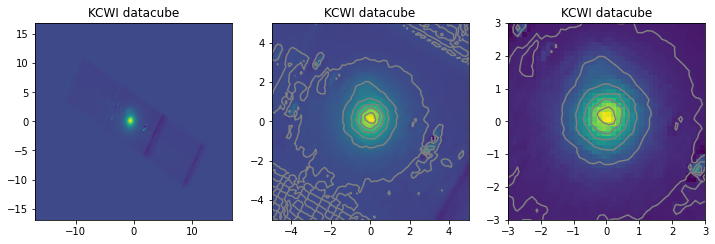

################################################
Calculating sky level


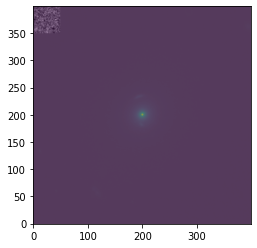

################################################
Smoothed log images for viewing


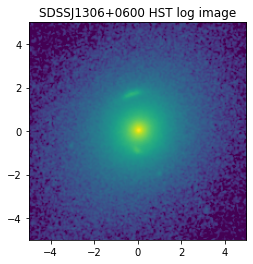

################################################
Estimating PSFs
################################################
KCWI PSF from hst image
(3,)
2
Best fit sigma-PSF is 0.22492483407539968 arcsec
Best fit loss function value is 0.00048532121654533937
Offsets: -1.6425159612497005,1.4103676881131137
Sum residual 1.259248217994664


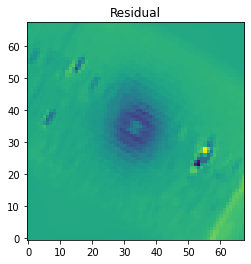

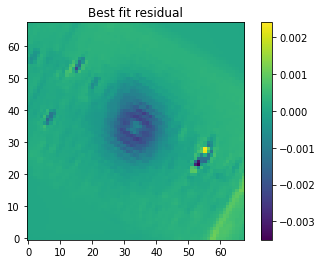

KCWI PSF FWHM = 0.5296979842475662 arcsec
################################################
HST PSF


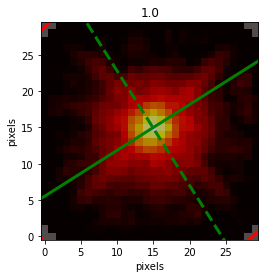

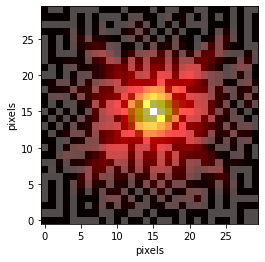

Iteration:1  chi2: 15.29  Nonzero: 8/12
Nonzero Gaussians: 6/12
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration:1  chi2: 15.06  Nonzero: 6/6
Nonzero Gaussians: 6/6
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 0.40 seconds
  Total Iterations:  8
 Nonzero Gaussians:  6
  Unused Gaussians:  6
 Sectors used in the fit:  19
 Total number of points fitted:  273
 Chi2: 15.06 
 STDEV: 0.2283 
 MEANABSDEV: 0.1841 
############################################
  Total_Counts  sigma_Pixels      q_obs
############################################
  1.726334e-01     0.380000     0.980000
  3.518410e-01     0.651565     0.980000
  3.732699e-01      1.18112     0.980000
  9.501692e-02      3.19116     0.980000
  2.915270e-02      8.14349     0.980000
  1.782932e-02      10.4596     0.987791
++++++++++++++++++++++++++++++++++++++++++++


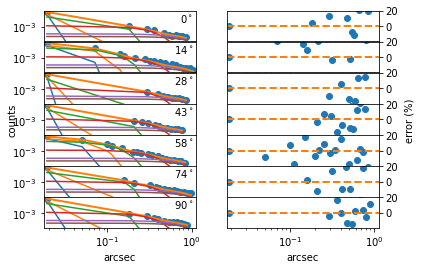

How good is the fit? Should be low (~ 0.02)... 0.18408168801657843
Check this minlevel


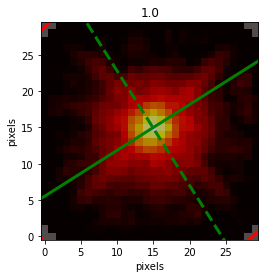

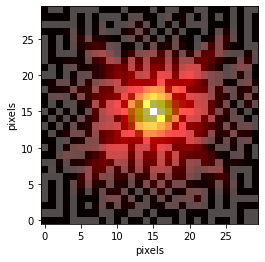

Iteration:1  chi2: 15.29  Nonzero: 8/12
Nonzero Gaussians: 6/12
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration:1  chi2: 15.06  Nonzero: 6/6
Nonzero Gaussians: 6/6
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 0.41 seconds
  Total Iterations:  8
 Nonzero Gaussians:  6
  Unused Gaussians:  6
 Sectors used in the fit:  19
 Total number of points fitted:  273
 Chi2: 15.06 
 STDEV: 0.2283 
 MEANABSDEV: 0.1841 
############################################
  Total_Counts  sigma_Pixels      q_obs
############################################
  1.726334e-01     0.380000     0.980000
  3.518410e-01     0.651565     0.980000
  3.732699e-01      1.18112     0.980000
  9.501692e-02      3.19116     0.980000
  2.915270e-02      8.14349     0.980000
  1.782932e-02      10.4596     0.987791
++++++++++++++++++++++++++++++++++++++++++++


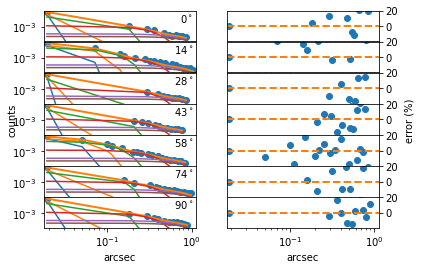

How good is the fit? Should be low (~ 0.02)... 0.18408168801657843
mean psf sigma is  0.0703457255453134
HST PSF FWHM = 0.16566418365921307 arcsec
################################################
Fitting photometry
################################################
First fit of central light ellipse


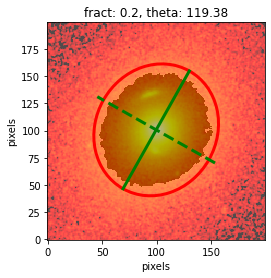

################################################
Calculating photometry of sectors


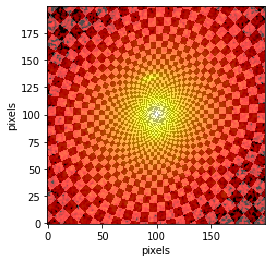

################################################
First MGE fit
Iteration:1  chi2: 2.117  Nonzero: 7/7


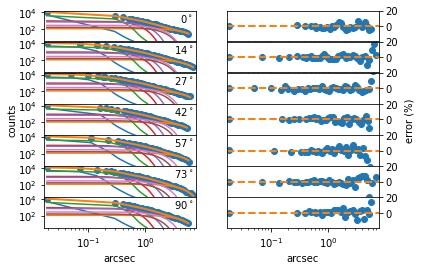

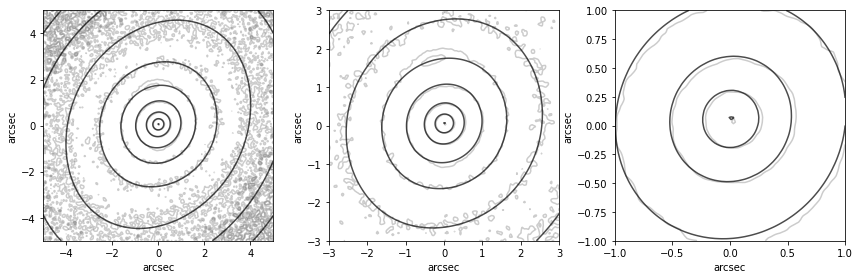

################################################
Regularized MGE fit
Iteration:1  chi2: 2.117  Nonzero: 7/7
(minloop) qbounds=0.0500 1.0000
############################################
Iteration:1  chi2: 2.117  Nonzero: 7/7
(minloop) qbounds=0.1000 1.0000
############################################
Iteration:1  chi2: 2.117  Nonzero: 7/7
(minloop) qbounds=0.1500 1.0000
############################################
Iteration:1  chi2: 2.117  Nonzero: 7/7
(minloop) qbounds=0.2000 1.0000
############################################
Iteration:1  chi2: 2.117  Nonzero: 7/7
(minloop) qbounds=0.2500 1.0000
############################################
Iteration:1  chi2: 2.117  Nonzero: 7/7
(minloop) qbounds=0.3000 1.0000
############################################
Iteration:1  chi2: 2.117  Nonzero: 7/7
(minloop) qbounds=0.3500 1.0000
############################################
Iteration:1  chi2: 2.117  Nonzero: 7/7
(minloop) qbounds=0.4000 1.0000
############################################
Ite

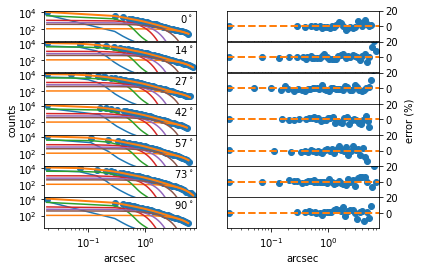

Best fit ellipticity = 0.1287151173558888


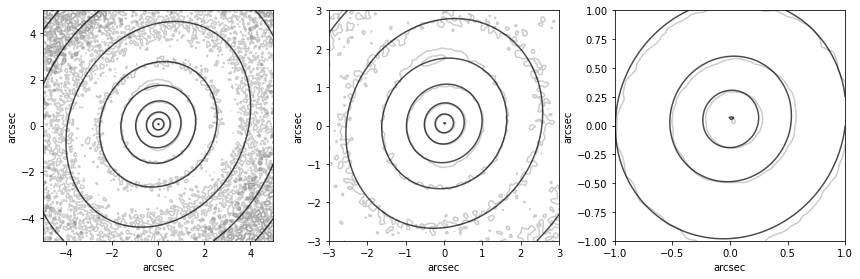

################################################
Converting to surface density and real units!
#################################################
Calculating half-light isophote and circularized half-light radius
effective radius mge:  1.5210967922814795
effective radius slacs:  []
################################################
Loading kinematics


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:356: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


<Figure size 432x288 with 0 Axes>

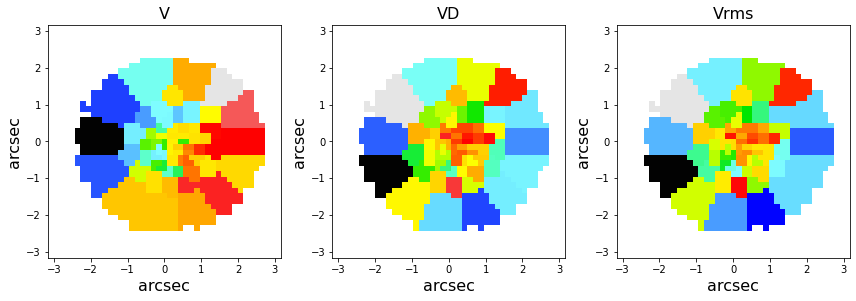

################################################
Binning velocity maps
################################################
Correcting barycentre velocity and calculating PA_kin
  Kin PA:  80.0  +/-  89.8  (3*sigma error)
Velocity Offset: -9.90


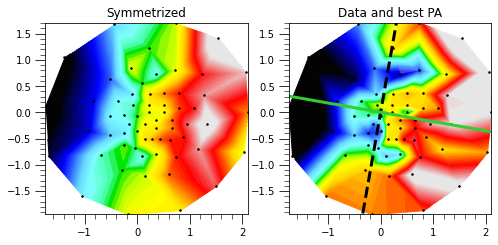

Checking PA by rotating bins by each PA
  Kin PA:  27.0  +/-  31.2  (3*sigma error)
Velocity Offset: -1.06


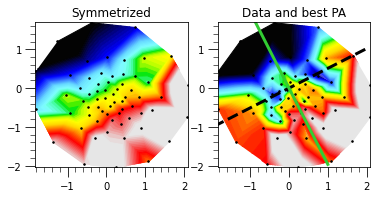

  Kin PA:  37.5  +/-  31.2  (3*sigma error)
Velocity Offset: -1.04


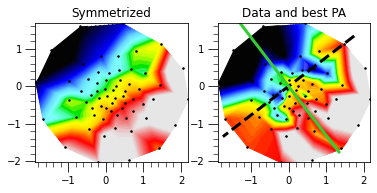

KCWI PA : [60.]
Kinematic PA: [140.]
Photometric PA: 150.624444449077
################################################
Calculating rms velocity
################################################
Plotting and saving velocity map without axis
################################################
Loading velocity map and rotating, adding to figure


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


################################################
Loading velocity map and rotating, adding to figure


<Figure size 432x288 with 0 Axes>

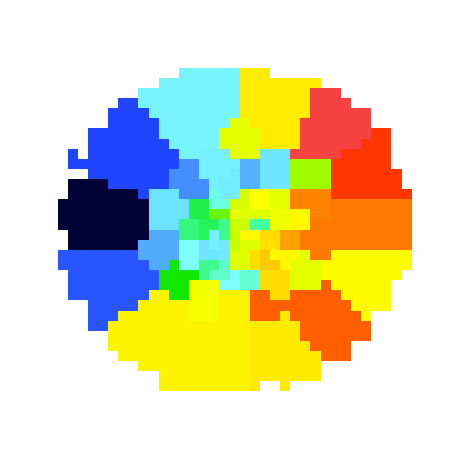

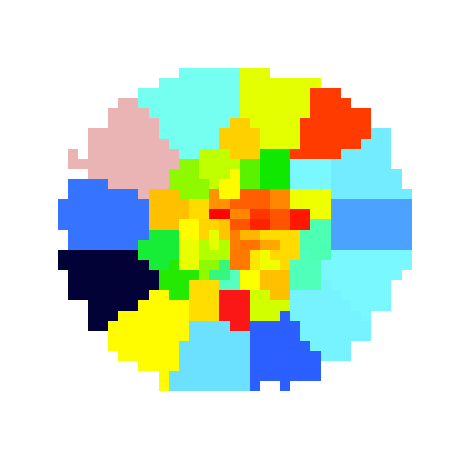

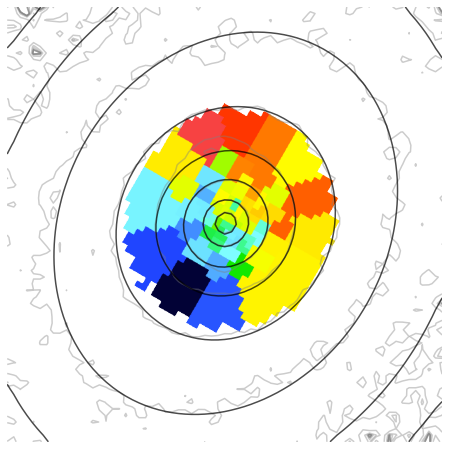

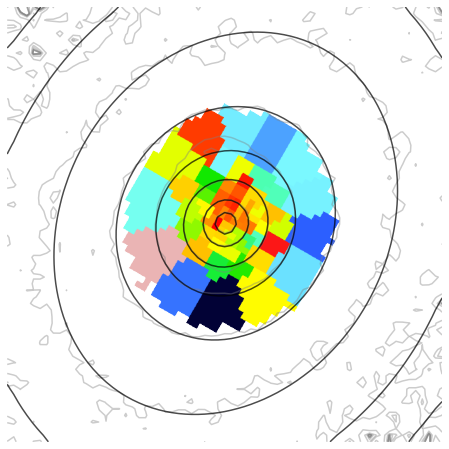

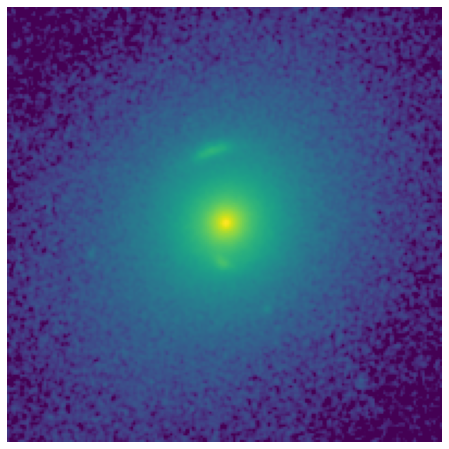

################################################
Loading velocity map and hst image and rotating, adding to figures
################################################
Aligning map and image along photometric PA
PA_kin  [140.]
PA_phot  150.624444449077
delta_PA  -10
delta_PA < 90 10


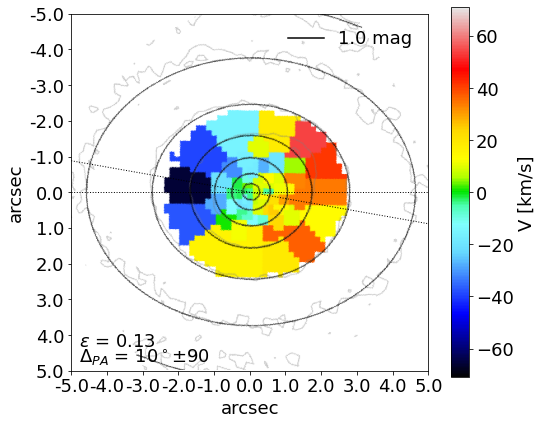

<Figure size 432x288 with 0 Axes>

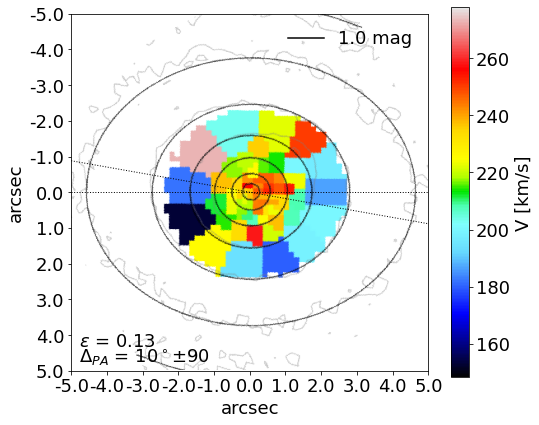

<Figure size 432x288 with 0 Axes>

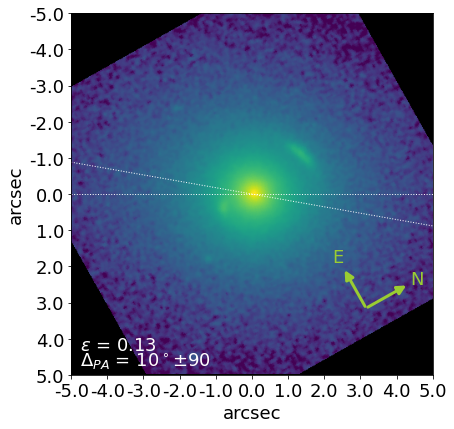

<Figure size 432x288 with 0 Axes>

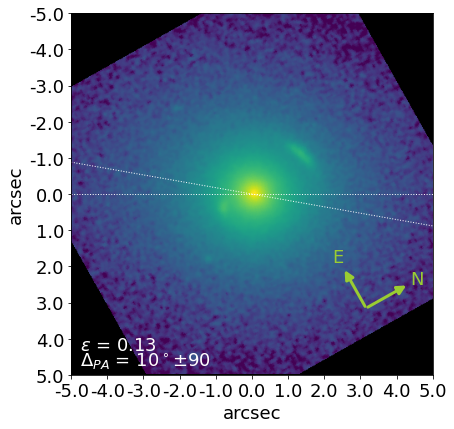

#########################################
Saving details for jampy use


################################################################################################################################
Job's finished!
[140.] 89.75 150.624444449077 -10 0.1287151173558888 0.22492483407539968


<Figure size 432x288 with 0 Axes>

In [29]:

#obj_name = obj_names[i]

# things I may want to tweak
frac = 0.2
levels = np.linspace(0.2, 1.0, 5)#[0.1, 0.2, 0.4, 0.7, 0.8]
binning = 3
magrange = 15
magsteps = 1.0

PA_kin, dPA_kin, PA_phot, \
    delta_PA, ellipticity, \
    kcwi_sigmapsf = plot_kinematics_mge_contours_j1306 (data_dir, hst_dir, obj_name, frac, levels, binning, magsteps, magrange,
                                                          # specific to j1306
                                                          hst_img=hst_img, hst_img_10=hst_img_10, hst_psf_model=psf, exp_time=3200,
                                                          add_rot_phot=True, add_rot_kin=True)#, debug=True)


print(PA_kin, dPA_kin, PA_phot, delta_PA, ellipticity, kcwi_sigmapsf)

In [30]:
# bring in my classifications table
load_date = '022223'
#class_df.to_csv(f'{data_dir}classification_table_{date}.csv',index=False)
classifications = pd.read_csv(f'{table_dir}classification_table_{load_date}.csv')

In [31]:
classifications.loc[6, 'PA_kin'] = PA_kin
classifications.loc[6, 'dPA_kin'] = dPA_kin
classifications.loc[6, 'PA_phot'] = PA_phot
classifications.loc[6, 'delta_PA'] = delta_PA
classifications.loc[6, 'ellipticity'] = ellipticity
classifications.loc[6, 'kcwi_sigmapsf'] = kcwi_sigmapsf


In [32]:
save_date = '022223'
classifications.to_csv(f'{table_dir}classification_table_{save_date}.csv')